In this notebook we will apply two different unsupervised learning methods to an image classification problem and compare the results, namely KMeans and Mean Shift. We will only use the RGB values of the images as features.

The source for the data is the Intel Image Classification dataset from Kaggle: https://www.kaggle.com/datasets/puneet6060/intel-image-classification.
Due to hardware constraints I will use only the training dataset and split it into training and testing, resize all images to 100x100, and only use 4 classes. Also note that running this notebook requires at least 16GB of RAM. You should also change the directories below to the ones where you extracted the image files.

Github: https://github.com/brnucub/dtsa5510

## Importing and preparing the data

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
pip install scikit-learn-extra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 46.9 MB/s eta 0:00:00


In [53]:
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import confusion_matrix
from skimage.transform import resize
from collections import Counter


In [3]:
labels = os.listdir('drive/MyDrive/datasets/seg_train/seg_train')
print(labels)

['buildings', 'forest', 'street', 'sea', 'glacier', 'mountain']


In [4]:
train_dir = 'drive/MyDrive/datasets/seg_train/seg_train/'

In [5]:
def get_images_in(dir, label):
  fdir = dir + label
  all_files = os.listdir(fdir)
  image_datas = []

  for filename in all_files:
    img = imread(os.path.join(fdir, filename))
    img = resize(img, (100, 100)) 
    image_datas.append(img)

  return image_datas



In [6]:
street_imgs = get_images_in(train_dir, 'street')
sea_imgs = get_images_in(train_dir, 'sea')
glacier_imgs = get_images_in(train_dir, 'glacier')
mountain_imgs = get_images_in(train_dir, 'mountain')

In [7]:
label_map = dict()
id_map = dict()
for i in range(len(labels)):
  label_map[labels[i]] = i
  id_map[i] = labels[i]

In [8]:
all_data = []
all_labels = []

for img in street_imgs:
  all_data.append(img)
  all_labels.append(label_map['street'])

for img in sea_imgs:
  all_data.append(img)
  all_labels.append(label_map['sea'])

for img in glacier_imgs:
  all_data.append(img)
  all_labels.append(label_map['glacier'])

for img in mountain_imgs:
  all_data.append(img)
  all_labels.append(label_map['mountain'])

In [9]:
def unroll_image(img):
  img_array = []
  for i in range(len(img)):
    for j in range(len(img[0])):
      color_values = img[i][j]
      img_array.append(color_values[0])
      img_array.append(color_values[1])
      img_array.append(color_values[2])
      
  return img_array


In [10]:
del street_imgs
del sea_imgs
del glacier_imgs
del mountain_imgs

In [11]:
for i in range(len(all_data)):
  all_data[i] = unroll_image(all_data[i])

In [12]:
all_data_unrolled = all_data

In [13]:
dims = len(all_data_unrolled[0])
for imgarray in all_data_unrolled:
  assert(len(imgarray) == dims)

In [14]:
def train_test_split(data, labels, pct):
  mapping = shuffle([*range(len(labels))], random_state=0)
  new_data = []
  new_labels = []

  for i in range(len(mapping)):
    new_data.append(data[mapping[i]])
    new_labels.append(labels[mapping[i]])

  split_idx = int(len(data)*pct)
  return new_data[split_idx:], new_labels[split_idx:], new_data[:split_idx], new_labels[:split_idx]

In [15]:
train_X, train_y, test_X, test_y = train_test_split(all_data_unrolled, all_labels, 0.1)

In [16]:
train_X = np.vstack(train_X)

## Exploratory Data Analysis

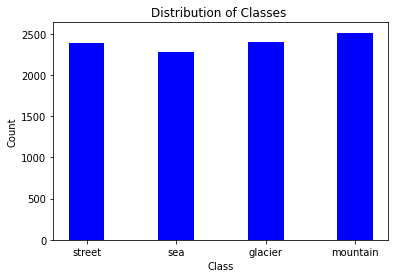

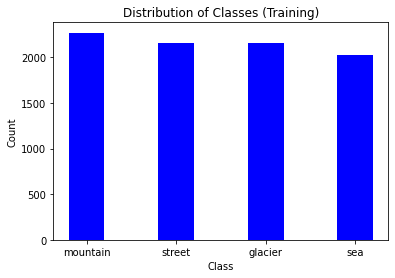

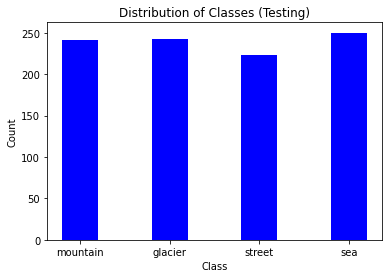

In [17]:
def plot_classes(labels, app):
  counts = Counter(labels)
  label_names = list(map(lambda x: id_map[x], counts.keys()))
  label_counts = counts.values()

  plt.bar(label_names, label_counts, color ='blue',
          width = 0.4)
  
  plt.xlabel("Class")
  plt.ylabel("Count")
  plt.title("Distribution of Classes " + app)
  plt.show()

plot_classes(all_labels, "")
plot_classes(train_y, "(Training)")
plot_classes(test_y, "(Testing)")

The distribution of classes is balanced well enough that we don't have to worry about majority bias. Something that might be interesting is the distribution of individual classes in terms of RGB channels, as this might affect how well they are clustered.

In [18]:
rgb_counter = dict()
counts = Counter(all_labels)

In [19]:
for item in counts.keys():
  rgb_counter[item] = [0,0,0]

for i in range(len(all_data)):
  for j in range(0, len(all_data[i]) - 3, 3):
    rgb_counter[all_labels[i]][j % 3] += all_data[i][j]
    rgb_counter[all_labels[i]][(j + 1) % 3] += all_data[i][j + 1]
    rgb_counter[all_labels[i]][(j + 2) % 3] += all_data[i][j + 2]

#average the results
for item in rgb_counter.keys():
  for i in range(3):
    rgb_counter[item][i] /= counts[item]

In [20]:
for item in rgb_counter.keys():
  for i in range(3):
    rgb_counter[item][i] /= 100*100

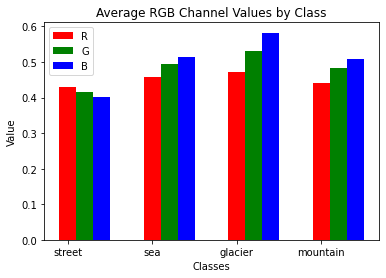

In [21]:
graph_labels = [id_map[x] for x in counts.keys()]
nR = [rgb_counter[x][0] for x in counts.keys()]
nG = [rgb_counter[x][1] for x in counts.keys()]
nB = [rgb_counter[x][2] for x in counts.keys()]
  
X_axis = np.arange(len(graph_labels))
  
plt.bar(X_axis, nR, 0.2, label = 'R', color='red')
plt.bar(X_axis + 0.2, nG, 0.2, label = 'G', color='green')
plt.bar(X_axis + 0.4, nB, 0.2, label = 'B', color='blue')

plt.xticks(X_axis, graph_labels)
plt.xlabel("Classes")
plt.ylabel("Value")
plt.title("Average RGB Channel Values by Class")
plt.legend()
plt.show()

Clearly there is noticeable variation in the RGB channels of each class of images. This should mean that they are somewhat easier to distinguish. However, most of them have a similar pattern of R < G < B, which may be confusing for the clustering algorithms.

## Model Building and Training

In [22]:
def acc(x_actual, y_pred):
  nc = 0

  for i in range(len(x_actual)):
    if x_actual[i] == y_pred[i]:
      nc += 1

  return nc/len(x_actual)

In [59]:
def best_mapping(x_actual, y_pred):
  best = None
  bestacc = 0

  maps = list(itertools.permutations(list(counts.keys())))

  for mapping in maps:
    tmp = [0, 1] + list(mapping)
    try_labels = [tmp[x + 2] for x in y_pred]
    map_acc = acc(x_actual, try_labels)

    if map_acc > bestacc:
      bestacc = map_acc
      best = mapping

  return bestacc, list(best)

In [54]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(train_X)

In [64]:
accuracy, mapping = best_mapping(train_y, kmeans.labels_)

In [65]:
accuracy

0.26012768427161925

In [66]:
mapping = [0, 0] + mapping

In [86]:
kmeans_pred = kmeans.predict(test_X)
kmeans_pred = [mapping[x + 2] for x in kmeans_pred]
test_accuracy = acc(test_y, kmeans_pred)

In [87]:
test_accuracy

0.2361546499477534

In [71]:
kmeans_cm = confusion_matrix(test_y, kmeans_pred)

We can see the classification accuracy above. One thing to consider here is that sklearn KMeans does not have a parameter for distance metric.

In [50]:
kmedoids = KMedoids(n_clusters=4, random_state=0, init='k-medoids++').fit(train_X)

In [73]:
accuracy, mapping = best_mapping(train_y, kmedoids.labels_)
mapping = [0, 0] + mapping

In [74]:
accuracy

0.2747533372025537

In [88]:
kmedoids_pred = kmedoids.predict(test_X)
kmedoids_pred = [mapping[x + 2] for x in kmedoids_pred]
test_accuracy = acc(test_y, kmedoids_pred)

In [89]:
test_accuracy

0.26854754440961337

In [77]:
kmedoids_cm = confusion_matrix(test_y, kmedoids_pred)

## Result

K-Means

Test Accuracy: 0.24


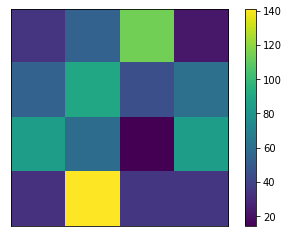

In [80]:
plt.imshow(kmeans_cm)
plt.xticks([])
plt.yticks([])
plt.colorbar();
print("Test Accuracy: 0.24")

K-Medoids

Test Accuracy: 0.27


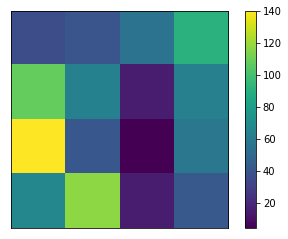

In [81]:
plt.imshow(kmedoids_cm)
plt.xticks([])
plt.yticks([])
plt.colorbar();
print("Test Accuracy: 0.27")

## Conclusion

Both K-Means and K-Medoids performed poorly on the image dataset. K-Medoids performed slightly better but based on the confusion matrices we can see that neither has classification ability using this approach. Both clustering methods were set to k-means++ initialization methods which improve clustering quality. It's difficult to tell what exactly enabled K-Medoids to perform slightly better. K-Means minimizes total squared error, K-Medoids minimizes dissimilarity between cluster members and their respective medoids. A few possibilities for improvement are to use transfer learning to generate the features, instead of using the raw RGB channel values that have been normalized, but the images had to be downsized due to hardware constraints, which probably also negatively affected the representation of their original feature values due to interpolation.